In [1]:
using DataFrames, CSV, DelimitedFiles, Plots, FFTW
include("/home/kirk/Documents/research/CHANDRATest/DJM.jl")

Main.DJM

In [2]:
function genFreqSums(powMatrix)
    sums=zeros(length(powMatrix[1,1,2:end]))
    for i in 1:length(powMatrix[1,1,2:end])
        sums[i]+=sum(powMatrix[:,:,i+1]) #i+1 becaus normal matrix is in 1st slice
    end
    return sums
end
function sumsLog(sums)
    sums4log=zeros(length(sums))
    for i in 1:length(sums4log)
        if sums[i]==0
            sums4log[i]=1
        else
            sums4log[i]=sums[i]
        end
    end
    return sums4log
end
function genFRange(df,powList)
    fbins=ceil(maximum(powList.freq[:])/df)
    frange=zeros(Int(fbins))
    for i in 1:length(frange)
        frange[i]=i*df
    end
    return frange
end

genFRange (generic function with 1 method)

In [3]:
pows8=CSV.read("cxc.fftinfo.all8")
maximum(pows8.power[:])

1896.4153897922079

In [4]:
pows8MatrixOVERLAP,pows8src=DJM.createPowMatrix(pows8,1)
sums8OVERLAP=genFreqSums(pows8MatrixOVERLAP)
sums8LogOVERLAP=sumsLog(sums8OVERLAP)

1255743 potential matches had the same obsid and were excluded.


1546-element Array{Float64,1}:
  8.0
  8.0
  5.0
  1.0
  6.0
 10.0
  1.0
  5.0
  3.0
  7.0
  9.0
  8.0
  6.0
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [5]:
pows8Matrix=DJM.createPowMatrix(pows8,0)

1255743 potential matches had the same obsid and were excluded.


101×101×1547 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …      0.0      0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0         0.0      0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0         0.0      0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0         0.0      0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0         0.0      0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …      0.0      0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0         0.0      0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0         0.0      0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     10385.0  10772.0  10772.0  792899.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      3901.0   4022.0   4022.0  296883.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   1569.0   1620.0   1620.0  119230.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       660.0    688.0    688.0   50555.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       386.0    400.0  

In [6]:
sums8=genFreqSums(pows8Matrix)
sums8Log=sumsLog(sums8)

1546-element Array{Float64,1}:
 2268.0
  789.0
  182.0
  287.0
  624.0
 1021.0
  134.0
  461.0
  211.0
  215.0
  127.0
   49.0
  196.0
    ⋮
    1.0
    1.0
    1.0
    2.0
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0

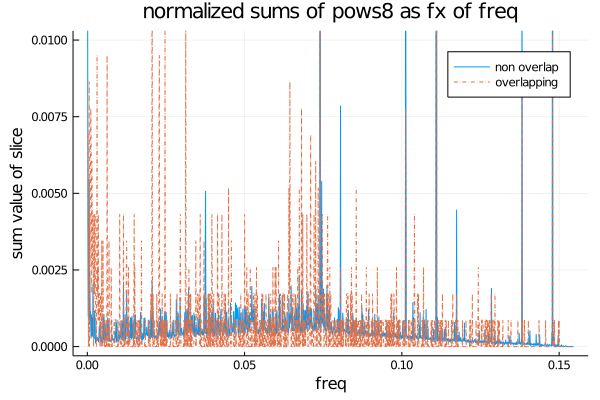

In [7]:
fRange8=genFRange(0.0001,pows8)
plot(fRange8,sums8./sum(sums8),title="normalized sums of pows8 as fx of freq",xlabel="freq",ylabel="sum value of slice",label="non overlap")
plot!(fRange8,sums8OVERLAP./sum(sums8OVERLAP),label="overlapping",linestyle=:dashdot,ylims=[0,0.01])

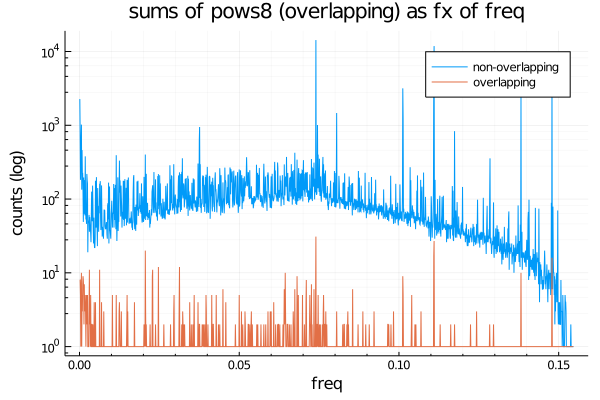

In [8]:
plot(fRange8,sums8Log,yaxis=:log,title="sums of pows8 (overlapping) as fx of freq",xlabel="freq",ylabel="counts (log)",label="non-overlapping",minorticks=true,minorgrid=true)
plot!(fRange8,sums8LogOVERLAP,label="overlapping")
#plot!(xlims=[0,0.04]) #this is for testing first result in checking_known_sources 

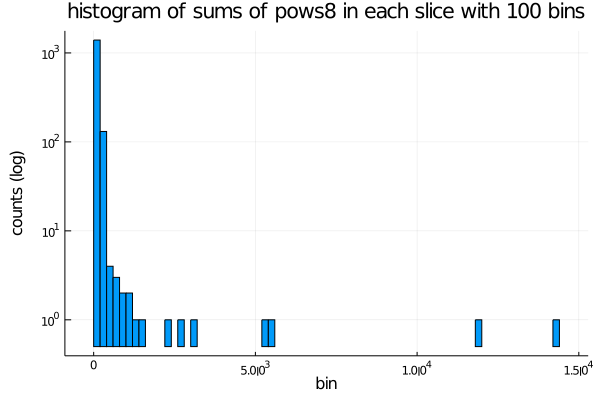

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error


In [9]:
histogram(sums8,bins=100,yaxis=:log,title="histogram of sums of pows8 in each slice with 100 bins",xlabel="bin",ylabel="counts (log)",label="")

In [10]:
pows12=CSV.read("cxc.fftinfo.all12")
pows12MatrixOVERLAP,pows12src=DJM.createPowMatrix(pows12,1)
sums12OVERLAP=genFreqSums(pows12MatrixOVERLAP)
sums12LogOVERLAP=sumsLog(sums12OVERLAP)

216981 potential matches had the same obsid and were excluded.


1544-element Array{Float64,1}:
 7.0
 1.0
 1.0
 1.0
 3.0
 1.0
 1.0
 3.0
 1.0
 1.0
 5.0
 8.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [11]:
pows12Matrix=DJM.createPowMatrix(pows12,0)
sums12=genFreqSums(pows12Matrix)
sums12Log=sumsLog(sums12)

216981 potential matches had the same obsid and were excluded.


1544-element Array{Float64,1}:
 1077.0
   96.0
   12.0
    9.0
  240.0
  263.0
   10.0
  208.0
   78.0
   26.0
   26.0
   16.0
   30.0
    ⋮
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0
    1.0

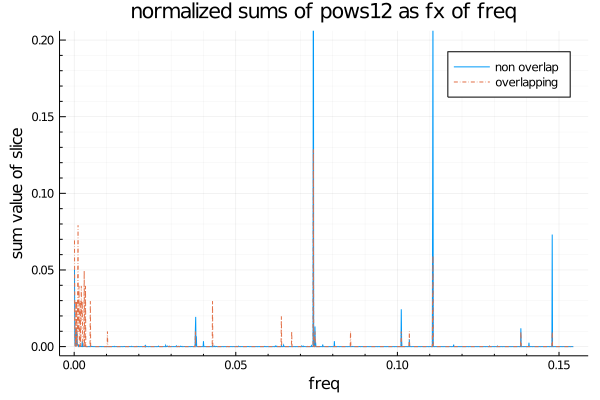

In [12]:
fRange12=genFRange(0.0001,pows12)
plot(fRange12,sums12./sum(sums12),title="normalized sums of pows12 as fx of freq",xlabel="freq",ylabel="sum value of slice",label="non overlap")
plot!(fRange12,sums12OVERLAP./sum(sums12OVERLAP),label="overlapping",linestyle=:dashdot,ylims=[0,0.2])
plot!(minorticks=true,minorgrid=true)
#plot!([0.107],seriestype=:vline,label="test freq")

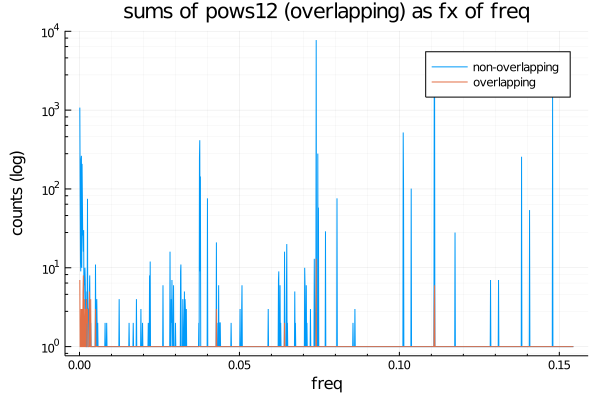

In [13]:
plot(fRange12,sums12Log,yaxis=:log,title="sums of pows12 (overlapping) as fx of freq",xlabel="freq",ylabel="counts (log)",label="non-overlapping",minorticks=true,minorgrid=true)
plot!(fRange12,sums12LogOVERLAP,label="overlapping")

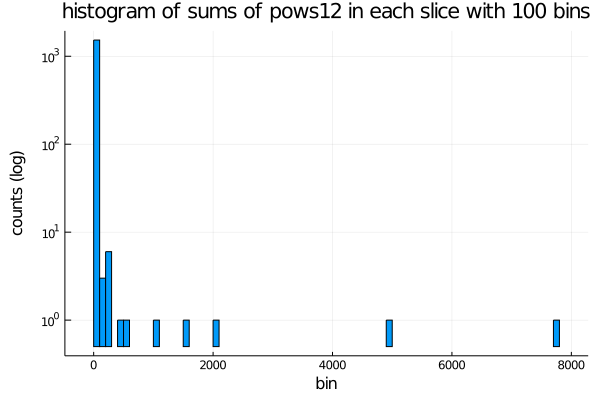

In [14]:
histogram(sums12,bins=100,yaxis=:log,title="histogram of sums of pows12 in each slice with 100 bins",xlabel="bin",ylabel="counts (log)",label="")

In [15]:
pows12src

101-element Array{Any,1}:
 [(22, 61)]
 [(23, 61)]
 [(26, 61)]
 [(26, 67)]
 [(27, 65)]
 [(27, 66)]
 [(72, 82)]
 [(72, 83)]
 [(72, 211)]
 [(82, 211)]
 [(83, 211)]
 [(87, 89)]
 [(87, 90)]
 ⋮
 [(1163, 1168)]
 [(1194, 1817)]
 [(1195, 1817)]
 [(1196, 1816)]
 [(1833, 1839)]
 [(1833, 1840)]
 [(1833, 1841)]
 [(1834, 1839)]
 [(1834, 1840)]
 [(1834, 1841)]
 [(1835, 1842)]
 [(1836, 1842)]

In [17]:
MCList=CSV.read("MCTestList.csv")

,name,ra,dec,porb,fx_limit,fx,fx_max,pulse_period
,String,Float64⍰,Float64⍰,Float64⍰,String⍰,Float64⍰,Float64⍰,Float64⍰
1,XTE SMC144s,missing,missing,61.2,missing,missing,missing,144.1
2,1H0103-762,17.3125,-74.7444,missing,missing,2.3,missing,missing
3,RX J0209.6-7427,32.405,-74.4533,missing,missing,10.6,missing,missing
4,RX J0032.9-7348,8.23375,-73.8053,missing,missing,0.2,missing,missing
5,AX J0042.0-7344,10.52,-73.7494,missing,missing,0.023,missing,missing
6,AX J0051.7-7341,12.9835,-73.6976,missing,missing,0.005,missing,missing
7,H 0053-739,13.6508,-73.6764,missing,<,1.0,50.0,2.37
8,AX J0101.4-7335,15.3658,-73.5833,missing,missing,0.02,missing,missing
9,RX J0050.7-7332,12.6954,-73.5467,missing,missing,0.003,missing,missing


In [30]:
raTest=MCList.ra[:]
decTest=MCList.dec[:]

128-element Array{Union{Missing, Float64},1}:
    missing
 -74.74444 
 -74.45333 
 -73.80528 
 -73.74944 
 -73.69761 
 -73.67639 
 -73.58333 
 -73.54667 
 -73.52361 
 -73.51361 
 -73.50389 
 -73.44639 
   ⋮       
 -66.20278 
 -66.1175  
 -66.10417 
 -65.9475  
 -65.87639 
 -65.86133 
 -65.8575  
 -65.66444 
 -65.58583 
 -65.50944 
 -65.30444 
 -64.08417 

In [32]:
function missing2Zero(col)
    for i=1:length(col)
        currEl=col[i]
        if ismissing(currEl)==true
            col[i]=0
        end
    end
    return col
end

missing2Zero (generic function with 1 method)

In [33]:
raMiss0=missing2Zero(raTest)
decMiss0=missing2Zero(decTest)

128-element Array{Union{Missing, Float64},1}:
   0.0    
 -74.74444
 -74.45333
 -73.80528
 -73.74944
 -73.69761
 -73.67639
 -73.58333
 -73.54667
 -73.52361
 -73.51361
 -73.50389
 -73.44639
   ⋮      
 -66.20278
 -66.1175 
 -66.10417
 -65.9475 
 -65.87639
 -65.86133
 -65.8575 
 -65.66444
 -65.58583
 -65.50944
 -65.30444
 -64.08417

In [52]:
periods=MCList.pulse_period[:]
periodsMiss0=missing2Zero(periods)
knownFreq=zeros(length(periodsMiss0))
for i=1:length(periodsMiss0)
    if periodsMiss0[i]==0
        knownFreq[i]=0
    else
        knownFreq[i]=1/periodsMiss0[i]
    end
end

In [53]:
nonZeroKnownFreq=[]
for el in knownFreq
    if el!=0 && el<0.15
        push!(nonZeroKnownFreq,el)
    end
end

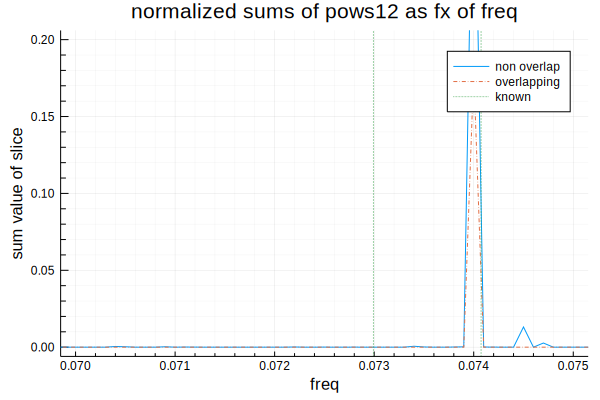

In [99]:
plot(fRange12,sums12./sum(sums12),title="normalized sums of pows12 as fx of freq",xlabel="freq",ylabel="sum value of slice",label="non overlap")
plot!(fRange12,sums12OVERLAP./sum(sums12OVERLAP),label="overlapping",linestyle=:dashdot,ylims=[0,0.2])
plot!(minorticks=true,minorgrid=true)
plot!(nonZeroKnownFreq,seriestype=:vline,linestyle=:dot,label="known")
plot!(xlims=[0.07,0.075])

### Tested two apparent pairs manually but neither in same physical place...

In [101]:
for i=1:length(nonZeroKnownFreq)
    if nonZeroKnownFreq[i]>0.073 && nonZeroKnownFreq[i]<0.075 #range guess from graph above
        println(nonZeroKnownFreq[i])
        global(testFreq=nonZeroKnownFreq[i])
    end
end

0.07407407407407407


In [102]:
for i=1:length(knownFreq)
    if knownFreq[i]==testFreq #find index where this value is in original list
        global(index)=i
    end
end

In [103]:
testDec=MCList.dec[index]
testRa=MCList.ra[index]
testperiod=MCList.pulse_period[index]

13.5

In [104]:
1/testperiod==testFreq

true

In [105]:
ind2check=[] #places to check if ra and dec match
for i=1:length(pows12src)
    freq1Ind=first.(pows12src[i])[1]
    freq2Ind=last.(pows12src[i])[1]
    avg=(pows12.freq[freq1Ind]+pows12.freq[freq2Ind])/2
    del=0.005
    if avg+del>testFreq && avg-del<testFreq
        println(avg)
        push!(ind2check,freq1Ind)
        push!(ind2check,freq2Ind)
    end
end
    

0.07396748407876955
0.07394762392166748
0.07394875150380256
0.07395474019589465
0.0739321776620899
0.0739529885980696
0.07395174345460183


In [106]:
for ind in ind2check
    raCheck=pows12.ra[ind]
    decCheck=pows12.dec[ind]
    rdist=DJM.gcdist(raCheck,decCheck,testRa,testDec)
    println(rdist)
end

70.50435510726179
70.50440752067044
70.46248800360613
70.46261380485288
70.43883290048626
70.43889420444292
70.06483286099424
70.06473172307727
70.02161339520505
70.02160512553145
70.02161339520505
70.02160512553145
69.97999638398845
69.98009501745415


In [88]:
pows12

,obsid,srcnum,startdate,exptime,ra,dec,freq,power
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1026,26,51833.8,6458.48,19.9382,-73.4501,0.00123975,13.2664
2,1028,105,51856.5,6324.74,19.038,-73.414,0.000316292,13.824
3,1028,113,51856.5,6324.74,18.9547,-73.4035,0.00110873,31.303
4,1028,113,51856.5,6324.74,18.9547,-73.4035,0.00126712,12.1519
5,1028,38,51856.5,6324.74,19.8812,-73.5169,0.00110816,21.5887
6,1028,88,51856.5,6324.74,19.1853,-73.4323,0.000316454,12.6433
7,1029,13,52024.6,6120.26,19.6143,-73.4658,0.00115807,56.0898
8,1030,14,52025.6,6152.72,19.6181,-73.4675,0.00114639,74.6027
9,1030,14,52025.6,6152.72,19.6181,-73.4675,0.00212901,18.2923
